<a href="https://colab.research.google.com/github/Furatus/4MLUP_Anthem/blob/main/4MLUP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <u>Apprentissage non supervisé - Étude des hymnes nationaux</u>

Ce document est un rapport d'étude des hymnes nationaux dans un contexte d'apprentissage non-supervisé. Il comporte plusieurs parties indispensables à l'analyse des différents hymnes.

On retrouvera (sommaire) :

- Une analyse exploratoire, bien que rapide car notre dataset ne comporte pas beaucoup de variables, on décrira rapidement les données qui nous sont fournies
- Un Patitionnement par K-means
- Un Partitionnement Hiérarchique

---

## Généralités du document | Définition des variables globales

On commence par importer toutes les librairies dont nous aurons besoin lors de cette étude:


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.text import TSNEVisualizer
from wordcloud import WordCloud
import geopandas as gpd
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

sns.set_theme(style="whitegrid")
sns.set_palette("pastel")

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["figure.figsize"] = (10, 6)

_(Le fichier csv est disponible sur kaggle, ou directement sur ce repository github)_


In [17]:
csvfileurl = "https://raw.githubusercontent.com/Furatus/4MLUP_Anthem/refs/heads/main/anthems.csv"

df_anthem = pd.read_csv(csvfileurl)

---

## Analyse Exploratoire

Notre analyse débute par un description générale du dataset :


In [18]:
df_anthem.info()
df_anthem.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Country    190 non-null    object
 1   Alpha-2    189 non-null    object
 2   Alpha-3    190 non-null    object
 3   Continent  190 non-null    object
 4   Anthem     190 non-null    object
dtypes: object(5)
memory usage: 7.5+ KB


,Country,Alpha-2,Alpha-3,Continent,Anthem
count,190,189,190,190,190
unique,190,188,190,6,188
top,Albania,CH,ALB,Africa,"We knew thee of old, O, divinely restored, By ..."
freq,1,2,1,56,2


On observe qu'il manque uniquement 1 seule valeur parmis tout le dataset, vérifions quel est le pays auquel la valeur manque


In [19]:
df_anthem[df_anthem['Alpha-2'].isna()]

,Country,Alpha-2,Alpha-3,Continent,Anthem
168,Namibia,NaN,NAM,Africa,Namibia land of the brave Freedom fight we he ...


La Namibie n'a pas de code alpha-2 dans ce dataset (Officillement, c'est "NA").


In [20]:
mask = df_anthem['Alpha-2'].isna()
df_anthem.loc[mask, 'Alpha-2'] = df_anthem.loc[mask, 'Country'].map({
    'Namibia': 'NA',
})

> 🤔 L'observation manquante pour `Namibia` peut être expliquée par le fait que le colonne `Alpha-2` a pour valeur `NA`, ce qui peut être mal interprété par pandas


Le Dataset étant maintenant très limité, l'analyse ne peut se porter que sur une seule variable : le continent.

Passons en revue la variable continent dans un pie chart :


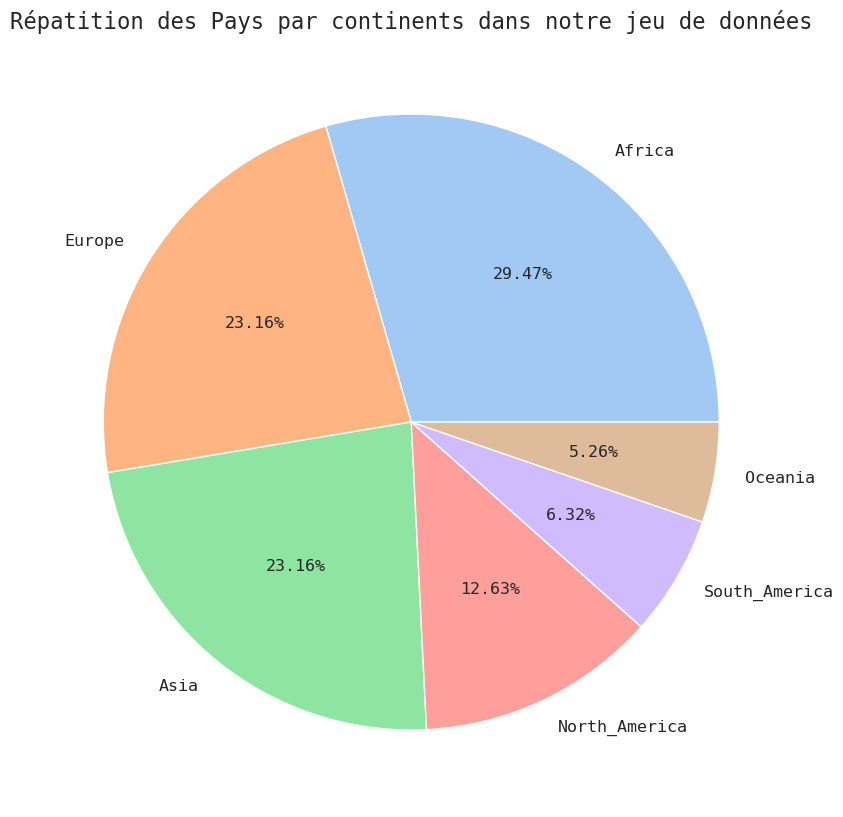

In [21]:
continent_counts = df_anthem['Continent'].value_counts()

plt.figure(figsize=(12,10))
plt.title('Répatition des Pays par continents dans notre jeu de données')
plt.pie(continent_counts, labels= continent_counts.index, autopct= '%.2f%%')
plt.show()


Observations :

- Les Pays d'Afrique, d'Asie et d'Europe sont les plus représentés de notre dataset.

> C'est une observation logique quand on sait que ce sont les continents qui concentrent le plus grand nombre de pays.

Notre analyse exploratoire se termine ici par manque de variables à analyser.


---

## Partitionnement par la méthode des K-Means

Le partitionnement des K-Means commencera par le téléchargement des différentes données nécessaires pour faire fonctionner le librairie nltk :


In [22]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/papylols/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/papylols/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/papylols/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/papylols/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [23]:
def preprocess_text(text):
    # Convertir en minuscules
    text = text.lower()
    # Supprimer la ponctuation
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

df_anthem['Anthem'] = df_anthem['Anthem'].apply(preprocess_text)
display(df_anthem['Anthem'])



0      around our flag we stand united with one wish ...
1      our fatherland free independent that has for c...
2      land of mountains land by the river land of fi...
3      azerbaijan azerbaijan the glorious fatherland ...
4      we belarusians are peaceful people wholehearte...
                             ...                        
185    o defenders of the homeland rally around to th...
186    oh uganda may god uphold thee we lay our futur...
187    o sons of the sahara in the battlefield you ar...
188    stand and sing of zambia proud and free land o...
189    oh lift high the banner the flag of zimbabwe t...
Name: Anthem, Length: 190, dtype: object

In [24]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df_anthem['Anthem'] = df_anthem['Anthem'].apply(lemmatize_text)

display(df_anthem['Anthem'])

0      around our flag we stand united with one wish ...
1      our fatherland free independent that ha for ce...
2      land of mountain land by the river land of fie...
3      azerbaijan azerbaijan the glorious fatherland ...
4      we belarusian are peaceful people wholehearted...
                             ...                        
185    o defender of the homeland rally around to the...
186    oh uganda may god uphold thee we lay our futur...
187    o son of the sahara in the battlefield you are...
188    stand and sing of zambia proud and free land o...
189    oh lift high the banner the flag of zimbabwe t...
Name: Anthem, Length: 190, dtype: object

In [25]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)
df_anthem['Anthem'] = df_anthem['Anthem'].apply(remove_stopwords)
display(df_anthem['Anthem'])

0      around flag stand united one wish one goal sac...
1      fatherland free independent ha century lived s...
2      land mountain land river land field land cathe...
3      azerbaijan azerbaijan glorious fatherland valo...
4      belarusian peaceful people wholeheartedly devo...
                             ...                        
185    defender homeland rally around glory time bloo...
186    oh uganda may god uphold thee lay future thy h...
187    son sahara battlefield torch holder long road ...
188    stand sing zambia proud free land work joy uni...
189    oh lift high banner flag zimbabwe symbol freed...
Name: Anthem, Length: 190, dtype: object

In [26]:
results = pd.DataFrame(columns=['instance_id','k', 'inertia', 'silhouette', 'tfidf_parameters'])

stopwords = nltk.corpus.stopwords.words('english')

tfidf_instances = [
    {
    'name': '50 features',
    'instance': TfidfVectorizer(max_features=50),
    },
    {
    'name': '100 features',
    'instance': TfidfVectorizer(max_features=100),
    },
    {
    'name': '250 features',
    'instance': TfidfVectorizer(max_features=250),
    },
    {
    'name': 'no limit features',
    'instance': TfidfVectorizer(max_features=None),
    },
    {
    'name': 'frequency ∈ [0.1, 0.9]',
    'instance': TfidfVectorizer(max_features=None, max_df=0.9, min_df=0.1), 
    },
    {
    'name': 'frequency ∈ [0.05, 0.95]',
    'instance': TfidfVectorizer(max_features=None, max_df=0.95, min_df=0.05), 
    },
    {
    'name': 'PCA',
    'instance': TfidfVectorizer(max_features=None), 
    }
]

for tfidf_instance in tfidf_instances:
    name = tfidf_instance['name']
    tfidf = tfidf_instance['instance']
    i = name
    X = tfidf.fit_transform(df_anthem['Anthem'])
    current_inertia = pd.DataFrame(columns=['k', 'inertia'])
    current_silhouette = pd.DataFrame(columns=['k', 'silhouette'])
    for k in range(2, 190):
        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(X)
        predicted_labels = kmeans.predict(X)
        current_inertia.loc[k] = [k, kmeans.inertia_]
        current_silhouette.loc[k] = [k, silhouette_score(X, predicted_labels)]
        
    tmp = pd.DataFrame({
        'instance_id': [i] * len(current_inertia),
        'k': current_inertia['k'],
        'inertia': current_inertia['inertia'],
        'silhouette': current_silhouette['silhouette'],
        'tfidf_parameters': [tfidf.get_params()] * len(current_inertia)
    })
    results = pd.concat([results, tmp], ignore_index=True)
    
display(results)

/home/papylols/miniforge3/envs/4EDAP/lib/python3.9/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (187) found smaller than n_clusters (188). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/papylols/miniforge3/envs/4EDAP/lib/python3.9/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (187) found smaller than n_clusters (189). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/tmp/ipykernel_19320/1975485175.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, tmp], ignore_index=True)
/home/papylols/miniforge3/envs/4EDAP/lib/python3.9/site-packages/sklearn/base.py

,instance_id,k,inertia,silhouette,tfidf_parameters
0,50 features,2.0,1.497797e+02,0.041139,"{'analyzer': 'word', 'binary': False, 'decode_..."
1,50 features,3.0,1.420266e+02,0.052590,"{'analyzer': 'word', 'binary': False, 'decode_..."
2,50 features,4.0,1.374523e+02,0.056258,"{'analyzer': 'word', 'binary': False, 'decode_..."
3,50 features,5.0,1.346319e+02,0.056871,"{'analyzer': 'word', 'binary': False, 'decode_..."
4,50 features,6.0,1.296956e+02,0.063450,"{'analyzer': 'word', 'binary': False, 'decode_..."
...,...,...,...,...,...
1311,PCA,185.0,1.230787e+00,0.034258,"{'analyzer': 'word', 'binary': False, 'decode_..."
1312,PCA,186.0,6.035310e-01,0.032726,"{'analyzer': 'word', 'binary': False, 'decode_..."
1313,PCA,187.0,4.394661e-03,0.030809,"{'analyzer': 'word', 'binary': False, 'decode_..."
1314,PCA,188.0,2.275957e-14,0.021053,"{'analyzer': 'word', 'binary': False, 'decode_..."


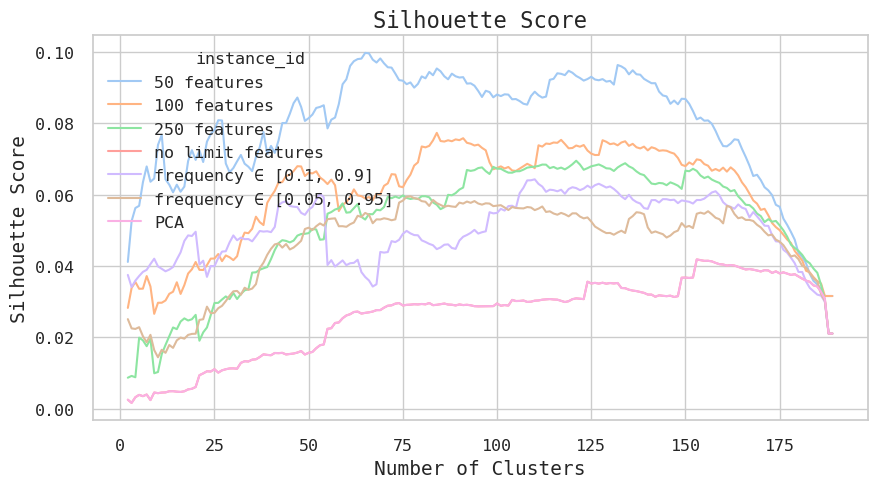

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(data=results, x='k', y='silhouette', hue='instance_id', ax=ax, palette='pastel')
ax.set_title('Silhouette Score')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
# ax.set_xticks(range(2,190))
plt.show()

In [28]:
results = pd.DataFrame(columns=['instance_id','k', 'inertia', 'silhouette', 'tfidf_parameters'])

for tfidf_instance in tfidf_instances:
    name = tfidf_instance['name']
    tfidf = tfidf_instance['instance']
    i = name
    X = tfidf.fit_transform(df_anthem['Anthem'])
    # display(pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out()))
    current_inertia = pd.DataFrame(columns=['k', 'inertia'])
    current_silhouette = pd.DataFrame(columns=['k', 'silhouette'])
    for k in range(75, 100):
        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(X)
        predicted_labels = kmeans.predict(X)
        current_inertia.loc[k] = [k, kmeans.inertia_]
        current_silhouette.loc[k] = [k, silhouette_score(X, predicted_labels)]
        
    tmp = pd.DataFrame({
        'instance_id': [i] * len(current_inertia),
        'k': current_inertia['k'],
        'inertia': current_inertia['inertia'],
        'silhouette': current_silhouette['silhouette'],
        'tfidf_parameters': [tfidf.get_params()] * len(current_inertia)
    })
    
    results = pd.concat([results, tmp], ignore_index=True)
    
display(results)

/tmp/ipykernel_19320/1757933691.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, tmp], ignore_index=True)


,instance_id,k,inertia,silhouette,tfidf_parameters
0,50 features,75.0,47.343371,0.091962,"{'analyzer': 'word', 'binary': False, 'decode_..."
1,50 features,76.0,46.808197,0.090985,"{'analyzer': 'word', 'binary': False, 'decode_..."
2,50 features,77.0,45.924284,0.091472,"{'analyzer': 'word', 'binary': False, 'decode_..."
3,50 features,78.0,45.478866,0.090015,"{'analyzer': 'word', 'binary': False, 'decode_..."
4,50 features,79.0,44.824038,0.091062,"{'analyzer': 'word', 'binary': False, 'decode_..."
...,...,...,...,...,...
170,PCA,95.0,79.146426,0.028676,"{'analyzer': 'word', 'binary': False, 'decode_..."
171,PCA,96.0,78.210004,0.028684,"{'analyzer': 'word', 'binary': False, 'decode_..."
172,PCA,97.0,77.261238,0.028688,"{'analyzer': 'word', 'binary': False, 'decode_..."
173,PCA,98.0,76.332491,0.028724,"{'analyzer': 'word', 'binary': False, 'decode_..."


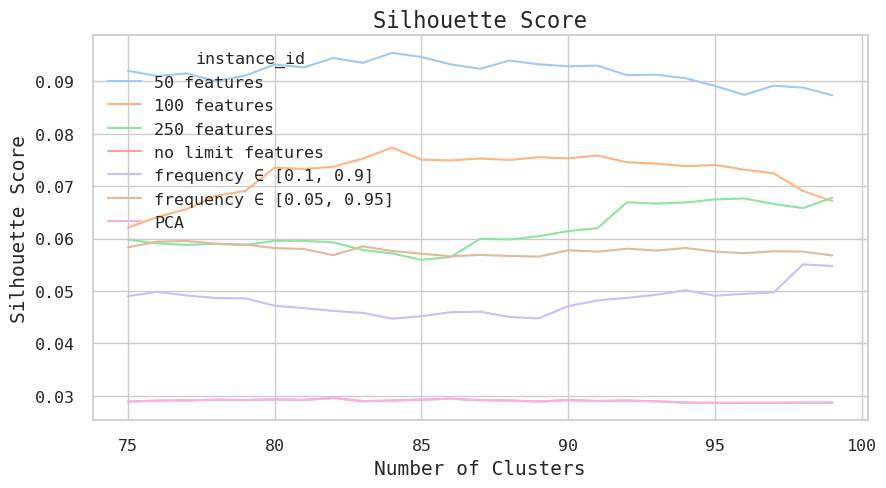

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(data=results, x='k', y='silhouette', hue='instance_id', ax=ax, palette='pastel')
ax.set_title('Silhouette Score')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
# ax.set_xticks(range(2,190))
plt.show()

> **Interprétation des silhouettes:**
>
> 💡 Le nombre de clusters à choisir correspond à la valeur maximale pour chaque instance du modèle.
>
> 🗒️ Le meilleur score général de silhouette revient à l'instance 0 du KMeans.
>
> Nombre optimal de clusters pour chaque instance:
>
> - `50 features`: 10 → 11
> - `100 features`: 7, 18 → 19
> - `250 features`: 5 → 8, 16 → 19
> - `frequency ∈ [0.1, 0.9]`: 9, 18 → 19
> - `frequency ∈ [0.05, 0.95]`: 3 → 5


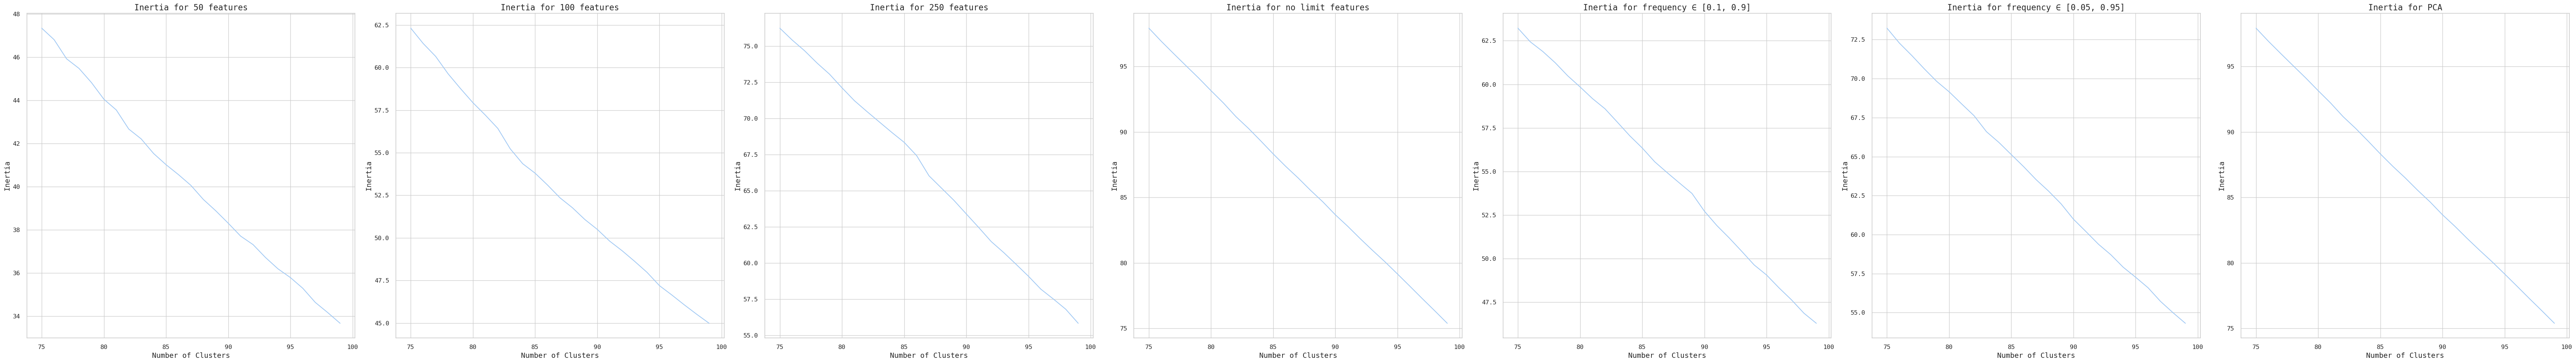

In [36]:
tfidf_instances = results['instance_id'].unique()
fig,ax = plt.subplots(1,len(tfidf_instances), figsize=(70, 10))
for model in tfidf_instances:
    currentAx = ax[list(tfidf_instances).index(model)]
    sns.lineplot(data=results[results['instance_id']==model], x='k', y='inertia', ax=currentAx)
    currentAx.set_title(f'Inertia for {model}')
    currentAx.set_xlabel('Number of Clusters')
    currentAx.set_ylabel('Inertia')
    # currentAx.set_xticks(range(2,21))
fig.tight_layout()
plt.show()

> **Interprétation des coudes:**
>
> 💡 Le nombre de clusters à choisir correspond à la cassure la plus nette des coudes
>
> 🗒️ Le meilleur score général de silhouette revient à l'instance 0 du KMeans.
>
> Nombre optimal de clusters pour chaque instance:
>
> - `instance_0`: 5 → 6
> - `instance_1`: 5 → 7
> - `instance_2`: 2
> - `instance_3`: 2
> - `instance_4`: 4
> - `instance_5`: 5


In [31]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
df_anthem['cluster'] = kmeans.labels_

<class 'scipy.sparse._csr.csr_matrix'>


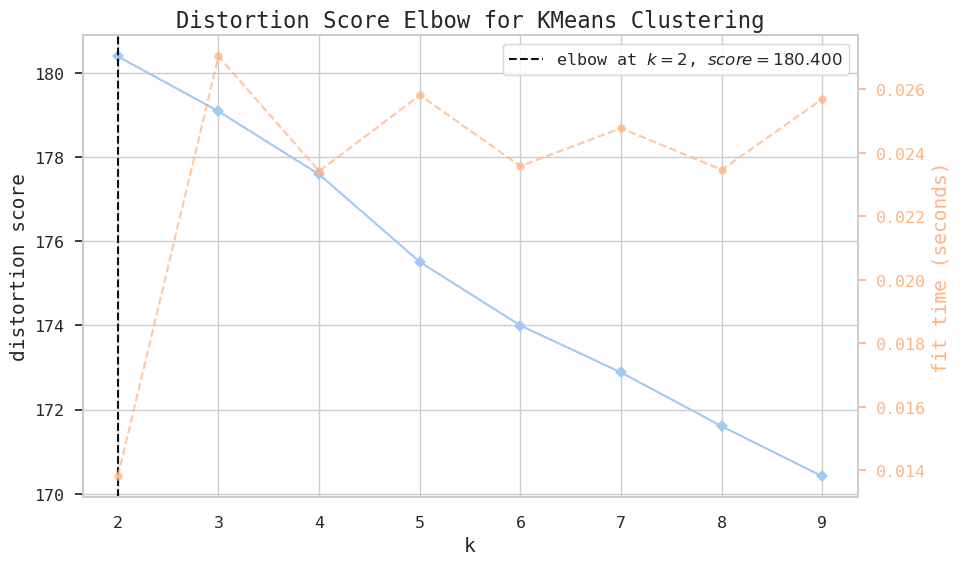

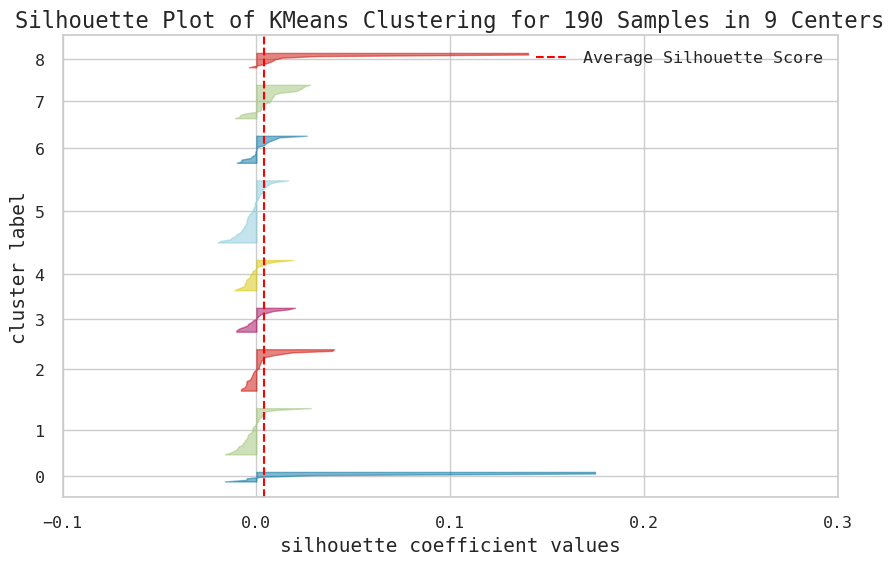

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 190 Samples in 9 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
print(type(X))

X_Array = X.toarray()

# Méthode du coude
visualizer = KElbowVisualizer(kmeans, k=(2,10))
visualizer.fit(X_Array)
visualizer.show()

# Méthode silhouette
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_Array)
visualizer.show()


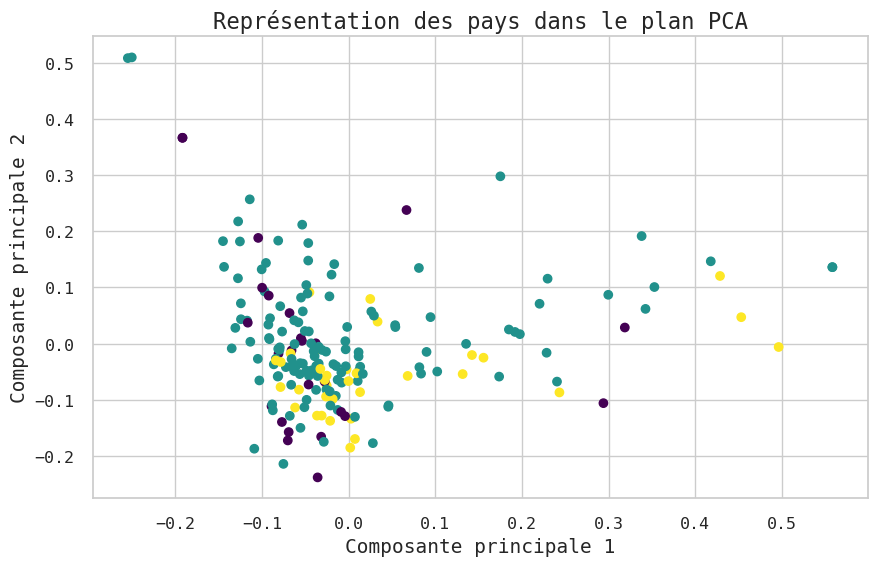

In [33]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_anthem['cluster'], cmap='viridis')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Représentation des pays dans le plan PCA')
plt.show()


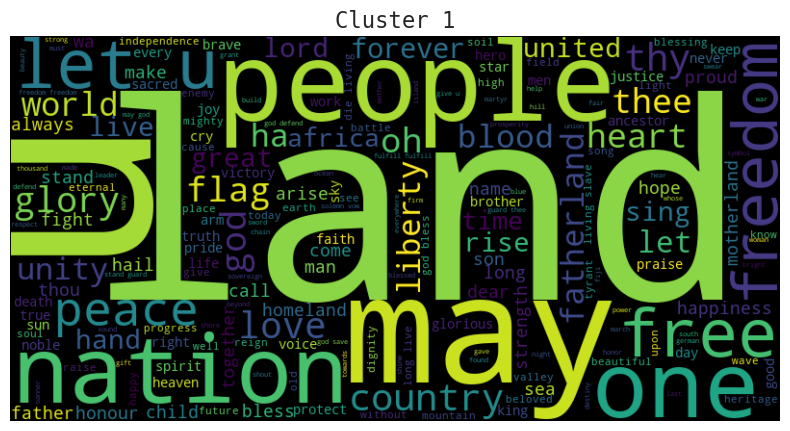

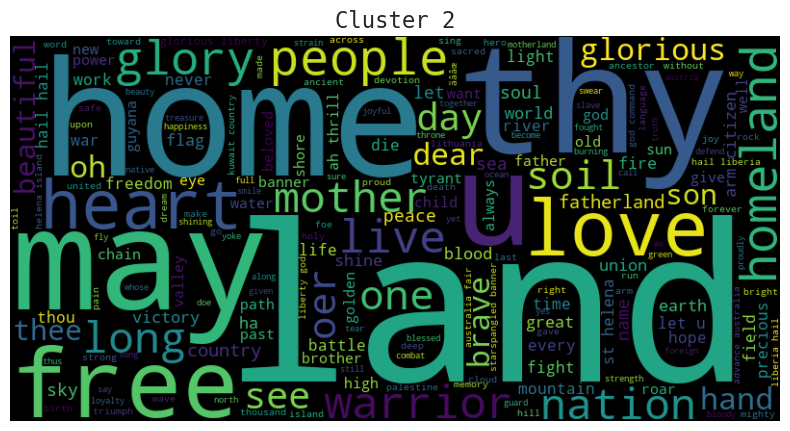

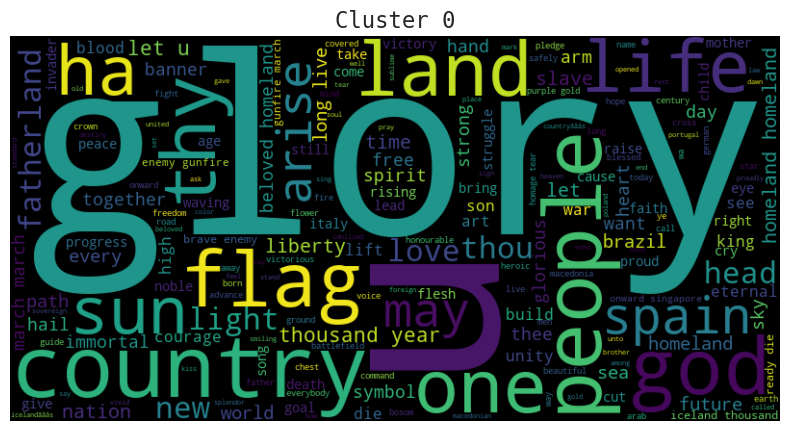

In [34]:
for cluster in df_anthem['cluster'].unique():
    text = ' '.join(df_anthem[df_anthem['cluster'] == cluster]['Anthem'])
    wordcloud = WordCloud(width=800, height=400).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster}')
    plt.axis('off')
    plt.show()



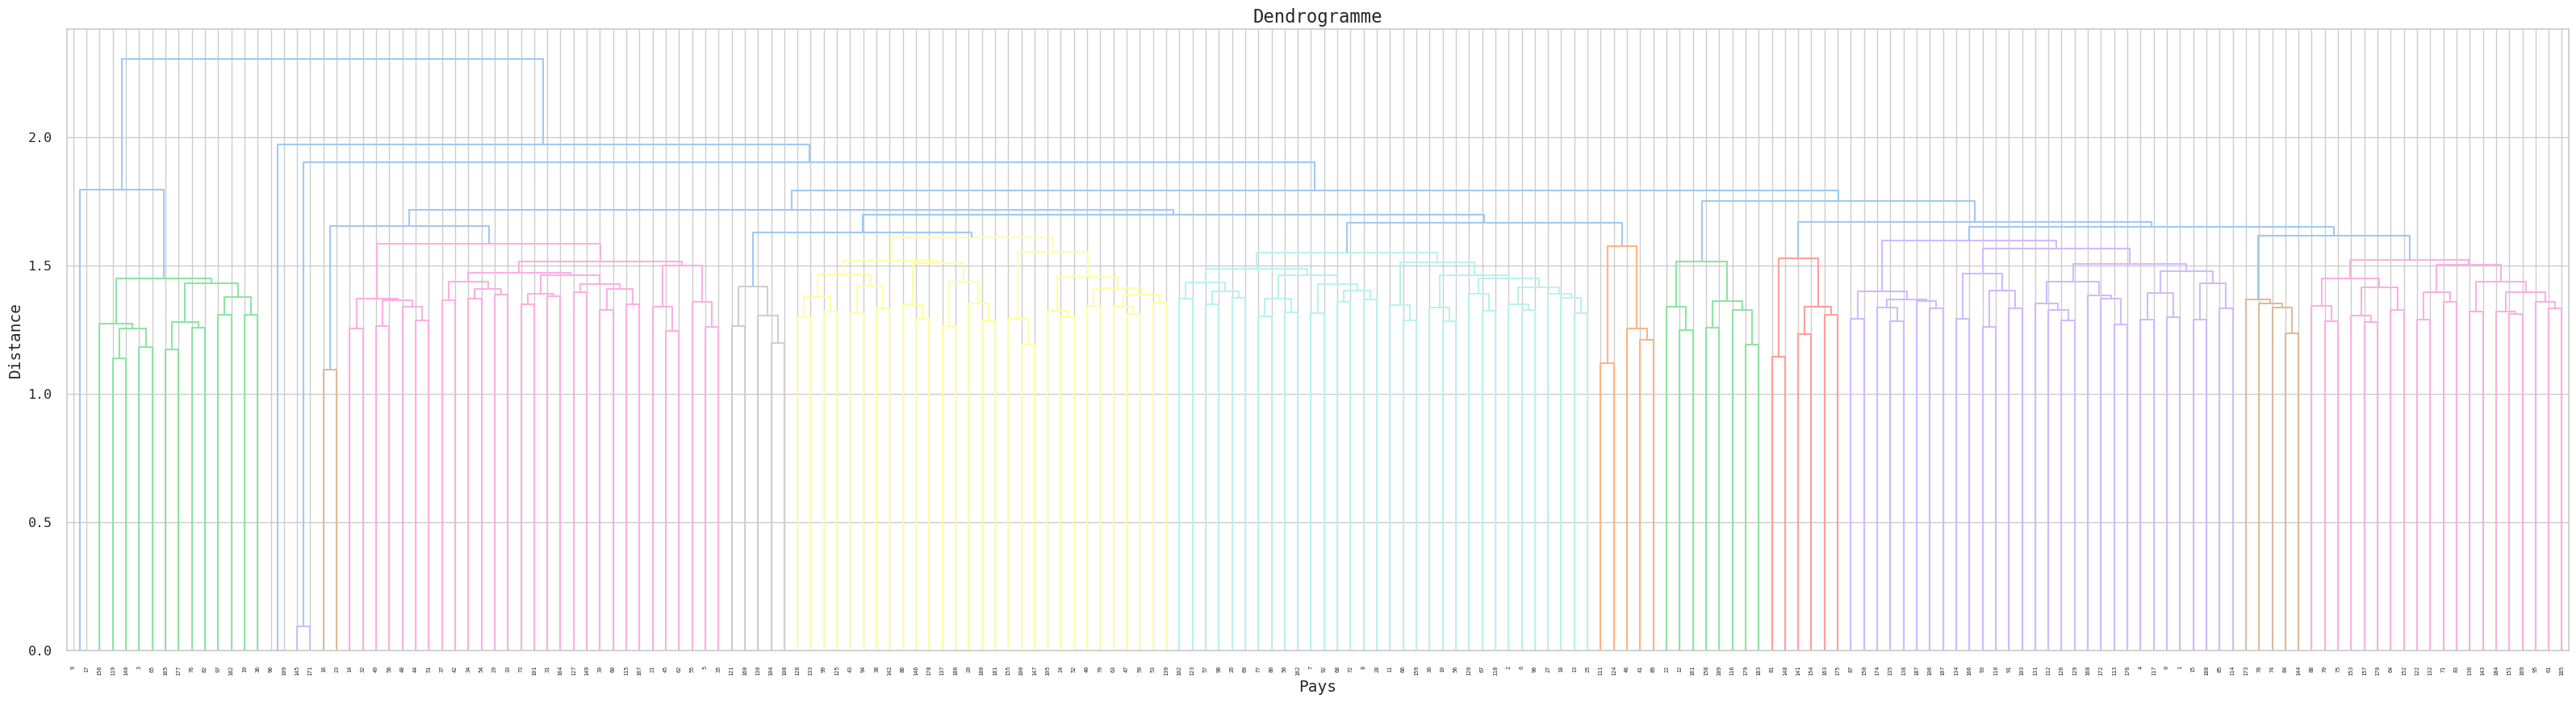

In [35]:
Z = linkage(X.toarray(), method='ward')

plt.figure(figsize=(40, 10))
dendrogram(Z)
plt.title('Dendrogramme')
plt.xlabel('Pays')
plt.ylabel('Distance')
plt.show()
